# 1. 라이브러리 import

In [1]:
import os

# 음성 데이터 처리
import librosa
import numpy as np
import pandas as pd

# 데이터 시각화
from matplotlib import pyplot as plt

# 모델 관련
import sklearn
from sklearn import preprocessing # AttributeError: module 'sklearn' has no attribute 'preprocessing'
import tensorflow as tf
import keras

# 노이즈 제거
# from df import enhance, init_df

2024-10-08 12:33:12.478123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 12:33:12.496539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 12:33:12.501991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 12:33:12.516013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# 2. GPU 관련 세팅

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

os.environ['CUDA_HOME']='/home/j-j11a210/.conda/envs/voice_strength'
os.environ['LD_LIBRARY_PATH']='/home/j-j11a210/.conda/envs/voice_strength/lib'

In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

I0000 00:00:1728358604.574319  301342 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728358604.641608  301342 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728358604.642278  301342 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728358604.786789  301342 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
# 3. 변수 설정

In [ ]:
# deepfilternet 사용 준비
# dfn_model, df_state, _ = init_df()

In [5]:
model_path = '/home/j-j11a210/EchoNote/AI/Voice_Strength/audio_anomaly_detection_mae.keras'

# sample rate at loaded
SAMPLE_RATE = 16000

# mfcc parameter
N_FFT = 400
HOP_LENGTH = 160
N_MELS = 64

# slicing window parameter
# 입력에 대해 일정 단위로 잘라서 모델에 넣는다.
WINDOW_SECOND = 30
HOP_SECOND = 0

# result data
mfcc_list = []
feature_list = []

In [11]:
# mae 임계값
threshold_mean = 0.02182374382391572
threshold_max = 0.08 # 0.11855171

# thresholds = np.array([5.9390197e-07, 1.4276836e-03, 1.2026135e-03, 1.0732074e-03, 7.0909178e-04,
#  5.3973543e-04, 4.0763570e-04, 3.1770475e-04, 3.7403271e-04, 2.7342548e-04,
#  2.8244586e-04, 2.5252026e-04, 3.4210877e-04, 2.9945065e-04, 2.2181304e-04,
#  2.3136209e-04, 2.4996133e-04, 2.1270799e-04, 2.6198488e-04, 2.9478868e-04])

In [ ]:
# 4. 오디오 분석 메소드

In [6]:
def load_audio(file_path):
    # 오디오 파일 로드
    assert os.path.isfile(file_path), "Wrong path to audio file"
    amplitude, _ = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # amplitude = librosa.to_mono(amplitude)
    # amplitude = enhance(dfn_model, df_state, segment)


    # WINDOW_SECOND가 10s이므로 파일이 10초보다 짧거나 HOP_SECOND의 배수가 아닌 경우 패딩을 추가합니다.
    window_frame = WINDOW_SECOND * SAMPLE_RATE

    if len(amplitude) % window_frame != 0:
      added_frame = window_frame - (len(amplitude) % window_frame)
      amplitude = librosa.util.fix_length(data=amplitude, size=len(amplitude) + added_frame)


    # input audio의 길이가 WINDOW_SECOND 보다 짧은 경우 (480000,)의 1차원 배열
    # print("amplitude shape: " + str(amplitude.shape))

    return amplitude

In [7]:
def extract_mfcc(frame):
    # print("frame shape: " + str(frame.shape)) # (480000,)
    mfcc = librosa.feature.mfcc(y=frame, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)

    # (n_mfcc, time_steps)를 전치시켜 시간에 따른 특성을 학습하도록 한다.
    mfcc = mfcc.T
    # print("mfcc shape: " + str(mfcc.shape)) # (3001, 20)

    # Z-score로 정규화 후 리턴 (keras의 예제에서도 이 방식을 선택)
    return sklearn.preprocessing.minmax_scale(mfcc, axis=1)

In [8]:
# 슬라이딩 윈도우를 적용해 오디오를 일정 크기의 프레임 단위로 나누는 함수
def audio_sliding_window(file_path, window_second=WINDOW_SECOND, hop_second=HOP_SECOND):
    amplitude = load_audio(file_path)

    # window_second(초)와 hop_second(초)를 샘플 단위로 변환
    window_samples = window_second * SAMPLE_RATE
    hop_samples = window_samples # 이전: hop_second * SAMPLE_RATE

    # 프레임 단위로 오디오를 슬라이딩 윈도우 기법으로 분할
    frame_list = librosa.util.frame(amplitude, frame_length=window_samples, hop_length=window_samples)
    # print("sliced frame shape: " + str(frame_list.shape))

    return frame_list.T

In [9]:
def create_data_frame(directory, audio_file_list):
    feature_list = []
    
    # 디렉토리 내 모든 오디오 파일에 대해
    audio_file_count = len(audio_file_list)
    for index, audio_file in enumerate(audio_file_list):
      print(str(index) + "/" + str(audio_file_count) + ": " + audio_file + " pre-prossessing...")


      # 오디오를 WINDOW_SECOND초 단위로 자른다.
      audio_full_path = os.path.join(directory, audio_file)
      frame_list = audio_sliding_window(audio_full_path, WINDOW_SECOND, HOP_SECOND)

      for frame in frame_list:
        new_frame = extract_mfcc(frame)
        feature_list.append(new_frame)
        # print("new_frame shape: " + str(new_frame.shape)) # (3001, 20)

    return np.array(feature_list)

In [10]:
def sec_to_timestamp(sec):
    hour = sec // (60*60)
    sec %= 60*60

    minute = sec // 60
    sec %= 60

    return '%02d:%02d:%02d' % (hour, minute, sec)

In [ ]:
# 5. 모델 사용 메서드

In [ ]:
def load_model():
    return tf.keras.models.load_model(model_path)

# 모델 로드
model = load_model()

In [ ]:
def get_abnormal_interval(directory, wav_file_list):
    if str(type(wav_file_list)) != "<class 'list'>":
        print("wav 파일 목록은 리스트로 주어져야 합니다.")
        return

    try:    
        # 실 데이터 불러오기
        test_data = create_data_frame(directory, wav_file_list)
        # test_data.shape # (n, 3001, 20)
    
        # 실제 predict(오토 인코더로 복원)
        predict_data = model.predict(test_data, batch_size=32) # (n, 3001, 20)
    
        
        return calc_abnormal_interval(test_data, predict_data)
        
    except Exception as e:
        print("err: " + str(e))

In [ ]:
def calc_abnormal_interval(original_data, predict_data):
    # mae loss 계산
    mae_loss_list = np.mean(np.abs(original_data - predict_data), axis=-1) # (n, 3001)

    test_threshold = np.mean(mae_loss_list) + 3 * np.std(mae_loss_list)
    
    # 이상값이 검출된 구간 탐색
    anomalous_seconds = []
    
    for list_idx, mae_loss in enumerate(mae_loss_list):
        # index = np.where(mae_loss > test_threshold)[0]
        index = np.where((mae_loss > test_threshold) & (mae_loss > threshold_max))[0]
        


    
    # print(index)
    for i in index:
        second = (i * HOP_LENGTH) / SAMPLE_RATE
        anomalous_seconds.append(second + WINDOW_SECOND * list_idx)

    print(anomalous_seconds)
    return anomalous_seconds

In [ ]:
# 6. 데이터 시각화 (X)

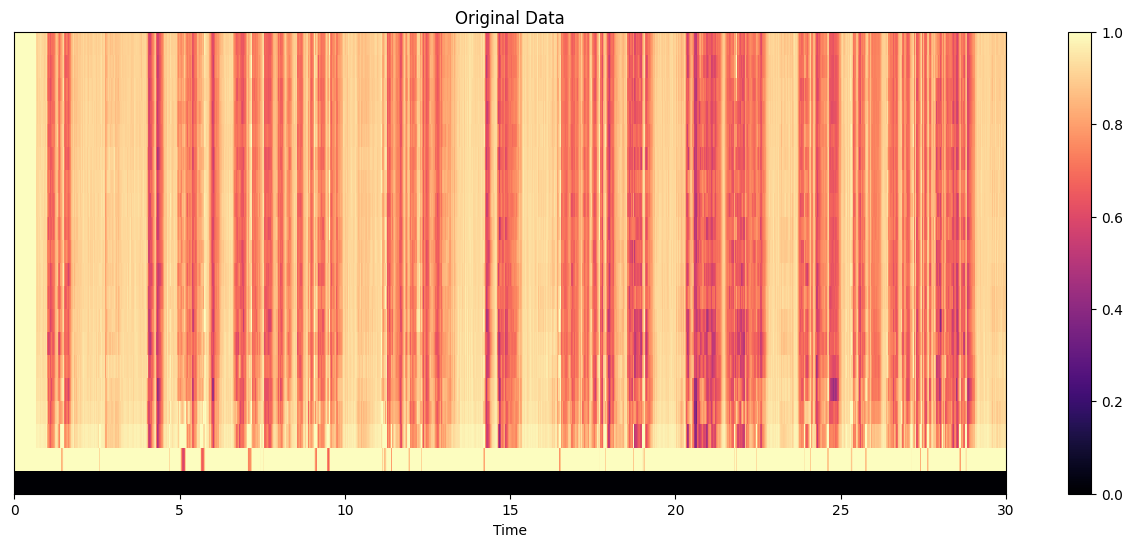

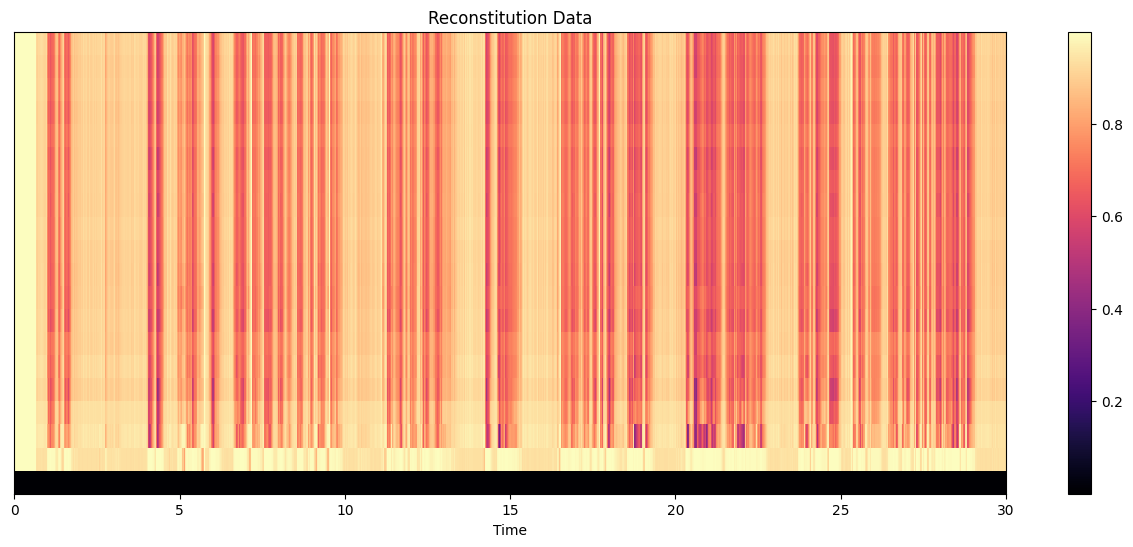

In [14]:
# plt.figure(figsize=(16, 6))
# librosa.display.specshow(test_data[0].T, sr=SAMPLE_RATE, x_axis='time', hop_length=HOP_LENGTH, n_fft=N_FFT)
# plt.title('Original Data')
# plt.colorbar()
# plt.show()


# plt.figure(figsize=(16, 6))
# librosa.display.specshow(test_predict_list[0].T, sr=SAMPLE_RATE, x_axis='time', hop_length=HOP_LENGTH, n_fft=N_FFT)
# plt.title("Reconstitution Data")
# plt.colorbar()
# plt.show()

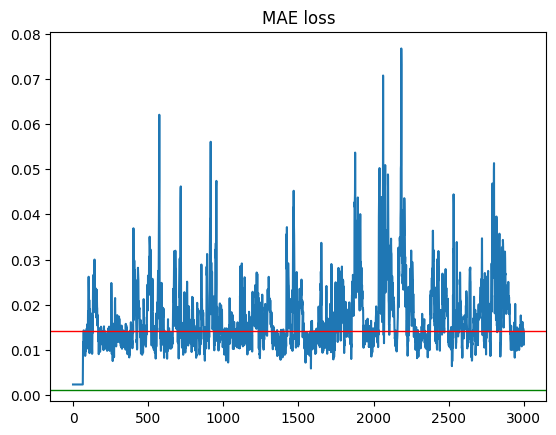

In [16]:
# plt.title("MAE loss")
# plt.plot(mae_loss_list[0])
# plt.axhline(y=threshold_max, color='r', linewidth=1)
# plt.axhline(y=threshold_mean, color='g', linewidth=1)
# plt.show()